## 4 . EVALUATION METRICS

Let's train the model again first - to use its results later in this notebook

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('data.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

In [5]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [6]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [7]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [9]:
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,1
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [10]:
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8055358410220014)

### 4.1 Accuracy and Dummy Models

Evaluate the model on different thresholds<br>
Check the accuracy of the dummy baselines

In [11]:
len(y_val)

1409

In [12]:
(y_val == churn_decision).mean()

np.float64(0.8055358410220014)

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
# Here the churn_decision is taken at 50%, now we can calculate this on multiple threshold

threshold = np.linspace(0, 1, 21)

scores = []

for t in threshold:
    # churn_decision = (y_pred >= t)
    # score = (y_val == churn_decision).mean()   this is our own formula, instead we can you from sklearn
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.508
0.10 0.605
0.15 0.664
0.20 0.705
0.25 0.738
0.30 0.759
0.35 0.767
0.40 0.781
0.45 0.793
0.50 0.806
0.55 0.804
0.60 0.800
0.65 0.787
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


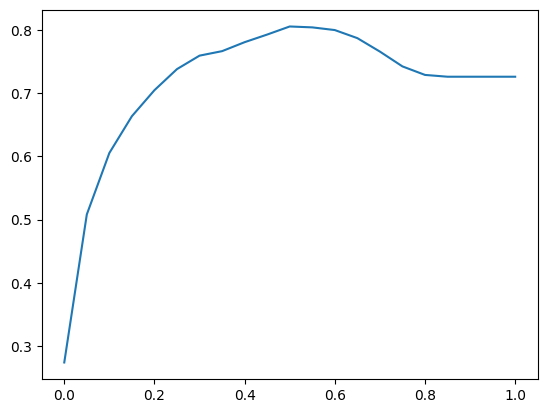

In [15]:
plt.plot(threshold, scores)

In [16]:
from collections import Counter

In [17]:
1 - y_val.mean()

np.float64(0.7260468417317246)

### 4.2 Confussion table

Different types of errors and correct decision<br>
Arranging them in a table

In [18]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [19]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [20]:
tp = (predict_positive & actual_positive).sum() # tp = True Positive
tn = (predict_negative & actual_negative).sum() # tn = True Negative

In [21]:
tp , tn

(np.int64(212), np.int64(923))

In [22]:
fp = (predict_positive & actual_negative).sum() # fp = False Positive
fn = (predict_negative & actual_positive).sum() # fn = False Negative

In [23]:
fp, fn

(np.int64(100), np.int64(174))

In [24]:
confusion_matrix = np.array(
     # predict neg    pos
    [[tn, fp], # actual neg
     [fn, tp]]) # actual pos

confusion_matrix

array([[923, 100],
       [174, 212]])

In [25]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.66, 0.07],
       [0.12, 0.15]])

### 4.3 Precision and Recall

In [26]:
(tp + tn)/ (tp + tn + fp + fn)

np.float64(0.8055358410220014)

In [27]:
p = tp / (tp + fp)
p # precision

np.float64(0.6794871794871795)

In [28]:
tp+ fp

np.int64(312)

In [29]:
r = tp / (tp + fn)
r # recall

np.float64(0.5492227979274611)

In [30]:
tp + fn

np.int64(386)

In [31]:
# So from this, we can see that accuracy is not the best matrics to evaluate this model in this senario
# The model failed to identify almost 45% of people going to churn and also sent additional offers for 32 % non-churning people

### 4.4 ROC Curve

#### TPR and FRP

In [32]:
# True Positive Rate 

trp = tp / (tp + fn)
# this vlaue is equal to recall value

In [33]:
# False Positive Rate

frp = fp / (fp + tn)

In [34]:
# Now lets find all these values at different threshold

threshold = np.linspace(0 , 1, 101)

scores = []

for t in threshold:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum() 
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum() 
    fn = (predict_negative & actual_positive).sum() 

    scores.append((t, tp, fp, tn, fn))

In [35]:
columns = ['threshold', 'tp', 'fp', 'tn', 'fn']
df_scores = pd.DataFrame(scores, columns = columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

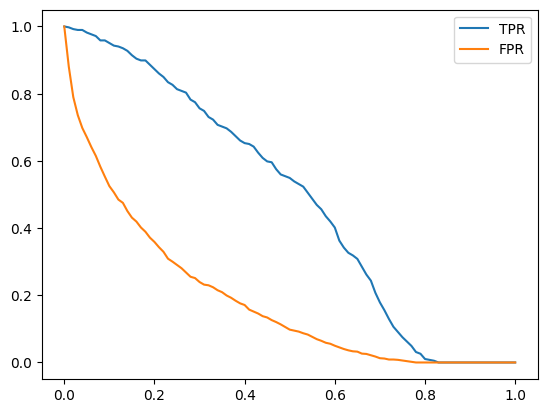

In [36]:
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR')
plt.legend()

#### Random Model

In [37]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size = len(y_val))

In [38]:
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089], shape=(1409,))

In [39]:
def tpr_fpr_dataframe(y_val, y_pred):
    threshold = np.linspace(0 , 1, 101)

    scores = []

    for t in threshold:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum() 
        tn = (predict_negative & actual_negative).sum()
    
        fp = (predict_positive & actual_negative).sum() 
        fn = (predict_negative & actual_positive).sum() 

        scores.append((t, tp, fp, tn, fn))

    columns = ['threshold', 'tp', 'fp', 'tn', 'fn']
    df_scores = pd.DataFrame(scores, columns = columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [40]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [41]:
df_rand[::10]

,threshold,tp,fp,tn,fn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,100,39,0.898964,0.902248
20,0.2,307,822,201,79,0.795337,0.803519
30,0.3,276,724,299,110,0.715026,0.707722
40,0.4,237,624,399,149,0.613990,0.609971
50,0.5,202,518,505,184,0.523316,0.506354
60,0.6,161,409,614,225,0.417098,0.399804
70,0.7,121,302,721,265,0.313472,0.295210
80,0.8,78,206,817,308,0.202073,0.201369
90,0.9,40,101,922,346,0.103627,0.098729


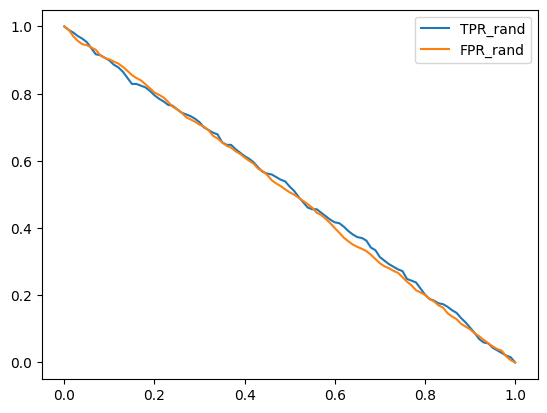

In [54]:
plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR_rand')
plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR_rand')
plt.legend()

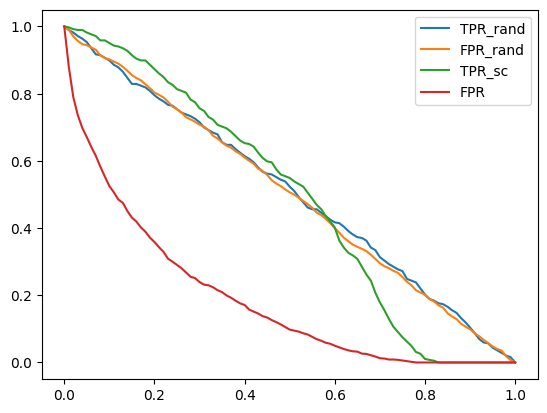

In [42]:
plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR_rand')
plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR_rand')
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR_sc')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR_sc')
plt.legend()

#### Ideal Model

In [43]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [44]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])

In [45]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [51]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

In [52]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

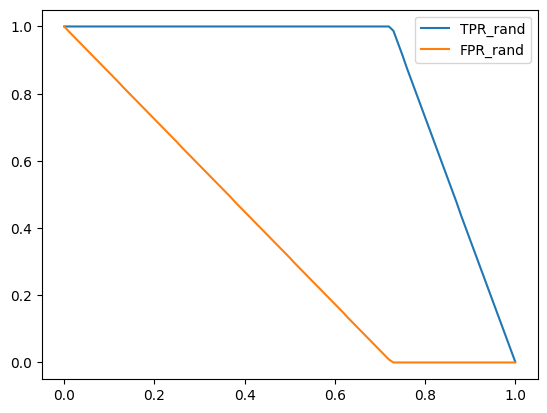

In [55]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'TPR_rand')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'FPR_rand')
plt.legend()

#### Putting everything together

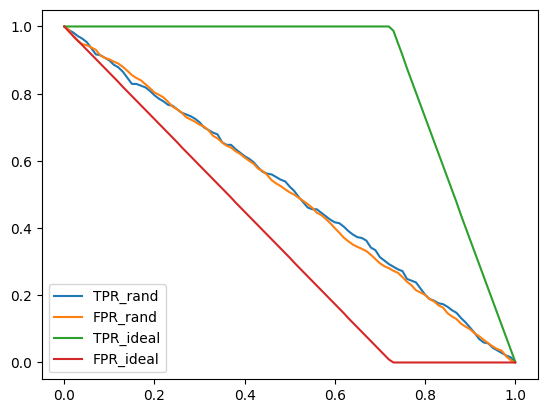

In [ ]:
#plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR_rand')
#plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR_rand')
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR_scores')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR_scores')
plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'TPR_ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'FPR_ideal')
plt.legend()